In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np



In [2]:
folder_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250604/SiH_Au/data'
folder_path_2 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250604/SiH_Au_H2O/data'

In [3]:
def extract_angle(filename):
    # Look for the last number at the end of the filename, even if there's no extension
    match = re.search(r"(\d+(?:\.\d+)?)\s*(?=\s*$|\.\w+$)", filename)
    return float(match.group(1)) if match else None


In [4]:
def extract_data_from_single_file(file_path):
    try:
        # Read comma-separated values
        df = pd.read_csv(file_path, sep=',', header=None, names=['wavenumber', 'R'], encoding='ISO-8859-1')
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None


In [5]:
# Function to iterate through the folder and extract data for different angles
def read_dpt_files_in_folder(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        angle = extract_angle(file)
        if angle is not None:
            # Construct the full file path
            file_path = os.path.join(folder_path, file)
            # Extract data from the file
            df = extract_data_from_single_file(file_path)
            if df is not None:
                data[angle] = df
        
            
            
    return data

In [6]:
data_y1 = read_dpt_files_in_folder(folder_path_1)
data_y2 = read_dpt_files_in_folder(folder_path_2)


In [7]:
#data_y2[34]

In [8]:
def compute_normed_ratio(data_y1, data_y2):
    data_ratio = {}

    for angle in data_y1:
        if angle in data_y2:
            df1 = data_y1[angle]
            df2 = data_y2[angle]

            # Ensure wavenumbers match
            if np.allclose(df1['wavenumber'], df2['wavenumber']):
                ratio = np.where(df1['R'] != 0, df2['R'] / df1['R'], np.nan)
                df_ratio = pd.DataFrame({
                    'wavenumber': df1['wavenumber'],
                    'Normed R': ratio
                })
                data_ratio[angle] = df_ratio
            else:
                print(f"Wavenumbers do not match at angle {angle}. Skipping.")
        else:
            print(f"Angle {angle} missing in data_y2. Skipping.")

    return data_ratio


In [9]:
data_normed = compute_normed_ratio(data_y1, data_y2)


In [10]:
#data_normed

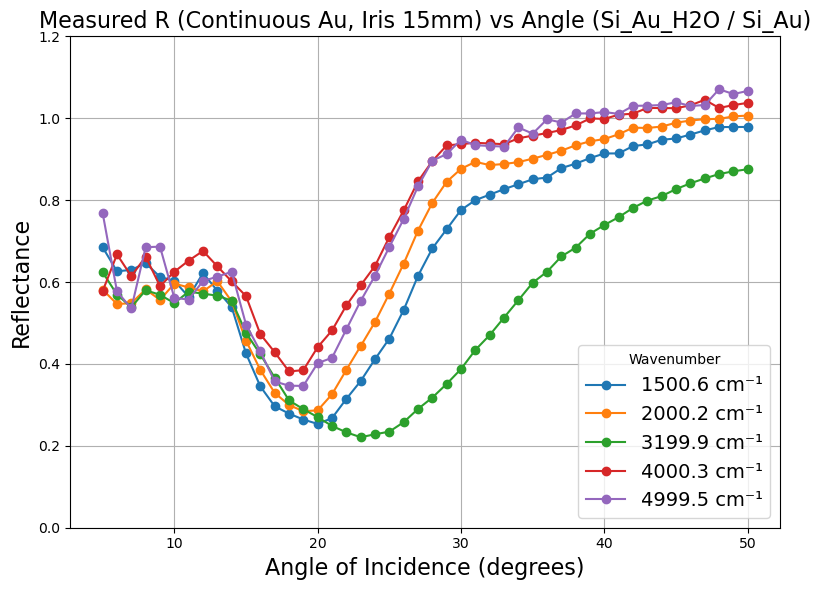

In [11]:
# --- SELECT wavenumbers to plot (will match to nearest available) ---
selected_wavenumbers = [1500, 2000,3200,4000, 5000]  # or any wavenumbers you want

# --- Sorted angle list from the dictionary ---
angles = sorted(data_normed.keys())

# --- Get available wavenumbers from any sample DataFrame ---
sample_df = next(iter(data_normed.values()))
available_wavenumbers = sample_df["wavenumber"].values

# --- Match to nearest available wavenumber ---
rounded_wavenumbers = [
    available_wavenumbers[np.argmin(np.abs(available_wavenumbers - wn))]
    for wn in selected_wavenumbers
]

# --- Plot reflectance vs angle for each wavenumber ---
plt.figure(figsize=(8, 6))

for wn in rounded_wavenumbers:
    reflectances = []
    for angle in angles:
        df = data_normed[angle]
        matched_row = df[np.isclose(df["wavenumber"], wn)]
        if not matched_row.empty:
            reflectances.append(matched_row["Normed R"].values[0])
        else:
            reflectances.append(np.nan)  # or 0, depending on preference

    plt.plot(angles, reflectances, marker='o', linestyle='-', label=f'{wn:.1f} cm⁻¹')

plt.title("Measured R (Continuous Au, Iris 15mm) vs Angle (Si_Au_H2O / Si_Au)", fontsize = 16)
plt.xlabel("Angle of Incidence (degrees)", fontsize = 16)
plt.ylabel("Reflectance", fontsize = 16)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize = 14)
plt.tight_layout()
plt.show()

In [12]:
anglelist = []
for i in range(20,31):
    anglelist.append(i)
#print(anglelist)    


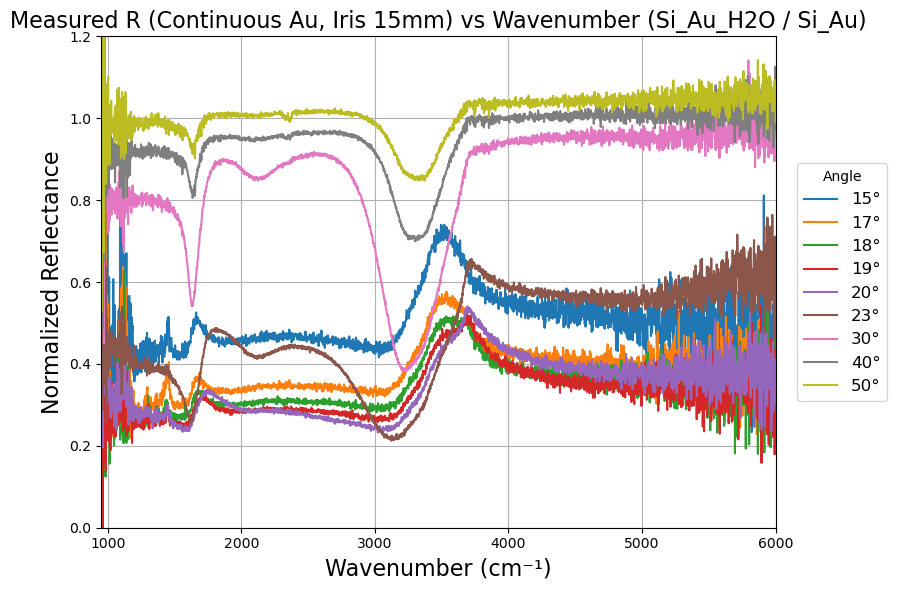

In [22]:
# --- SELECT angles
selected_angles = [15, 17,18, 19,20, 23, 30, 40, 50]  # Update this list as you wish
#selected_angles = anglelist

# --- Plot reflectance vs wavenumber for selected angles ---
plt.figure(figsize=(11, 6))

for angle in selected_angles:
    if angle not in data_normed:
        print(f"Warning: angle {angle}° not found in data_normed.")
        continue

    df = data_normed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Normed R"].values
    plt.plot(wavenumbers, reflectance, label=f"{angle}°")

plt.title("Measured R (Continuous Au, Iris 15mm) vs Wavenumber (Si_Au_H2O / Si_Au)", fontsize = 16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize = 16)
plt.ylabel("Normalized Reflectance", fontsize = 16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend
plt.show()


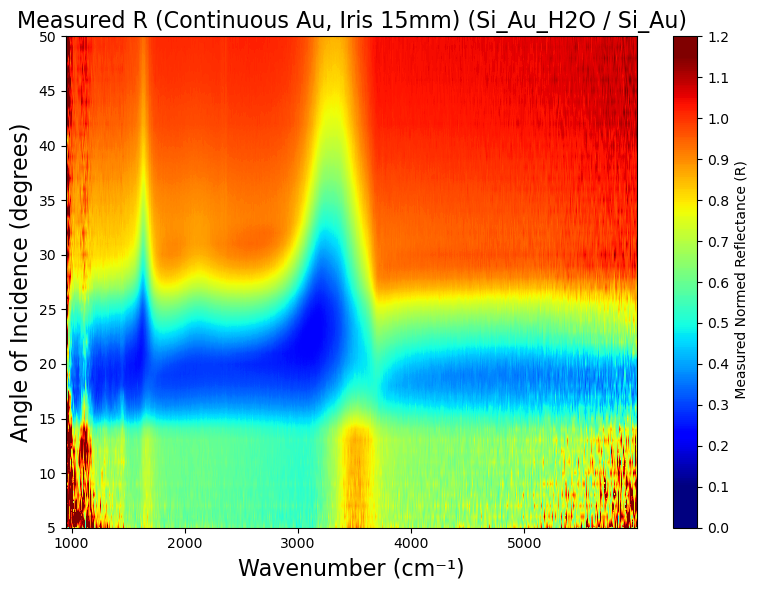

In [21]:
# --- Get sorted list of angles ---
angles = sorted(data_normed.keys())

# --- Extract wavenumbers from one sample DataFrame ---
sample_df = next(iter(data_normed.values()))
wavenumbers = sample_df['wavenumber'].values

# --- Optional: clip wavenumber range ---
wmin, wmax = 950, 6000
mask = (wavenumbers >= wmin) & (wavenumbers <= wmax)
wavenumbers_clipped = wavenumbers[mask]

# --- Build 2D array for Normed R ---
R_matrix = np.array([
    data_normed[angle]['Normed R'].values[mask]
    for angle in angles
])

# --- Meshgrid for contour plotting ---
W_grid, A_grid = np.meshgrid(wavenumbers_clipped, angles)
levels = np.linspace(0, 1.2, 256)

# --- Plot contour ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(W_grid, A_grid, R_matrix, levels=levels, cmap='jet', vmin=0.1, vmax=1.15)
cbar = plt.colorbar(contour)
cbar.set_label(' Measured Normed Reflectance (R)')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8, 0.9,1.0,1.1, 1.2])  # optional, customizable

plt.title('Measured R (Continuous Au, Iris 15mm) (Si_Au_H2O / Si_Au)', fontsize=16)
plt.xlabel('Wavenumber (cm⁻¹)', fontsize=16)
plt.ylabel('Angle of Incidence (degrees)', fontsize=16)
plt.tight_layout()
plt.show()
